Усложните модель UNET с семинара, обучите ее на датасете OXFORD-PETS, добейтесь попиксельной Accuracy в 88%. Для этого вам понадобится добавить в нее еще блоков вниз и блоков вверх, а также возможно увеличить base_channels.

Используйте следующий трансформ для изображений:

transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)


Сдайте свои предсказания для тестовой выборки этого датасета (split='test'). Сделайте предсказания для следующих объектов:

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)


Загрузите свои предсказания в чекер, воспользуйтесь функциями torch.save, ваш тензор с предсказаниями должен иметь размер [200, 1, 256, 256].



In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#!g1.1
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('./data/pets', target_types='segmentation')

In [3]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

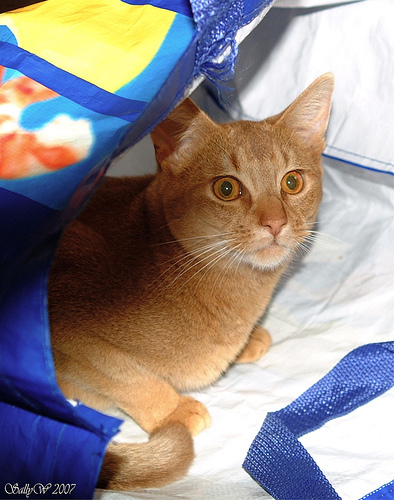

In [4]:
dataset[0][0]

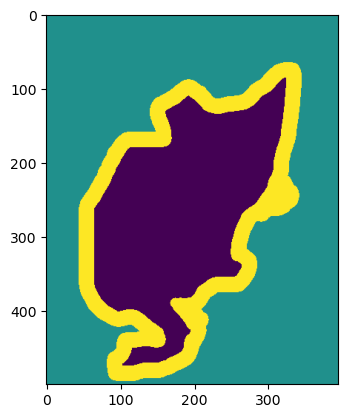

In [5]:
plt.imshow(dataset[0][1])

In [6]:
#!g1.1
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('./data/pets', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('./data/pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')


In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [8]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x, y.squeeze(1)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [9]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x, y.squeeze(1)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [10]:
#!g1.1
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [11]:
#!g1.1
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch

    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0)).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break


In [12]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_plus_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32 
        
        # Down path
        self.down1 = conv_plus_conv(3, base_channels)                    # 3 -> 32
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)    # 32 -> 64
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4) # 64 -> 128
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8) # 128 -> 256
        
        # Up path - ПРАВИЛЬНЫЕ РАСЧЕТЫ:
        # up1: bottleneck(512) + residual4(256) = 768 входных каналов
        self.up1 = conv_plus_conv(768, base_channels * 8)  # 768 -> 256
        # up2: up1_out(256) + residual3(128) = 384 входных каналов  
        self.up2 = conv_plus_conv(384, base_channels * 4)  # 384 -> 128
        # up3: up2_out(128) + residual2(64) = 192 входных канала
        self.up3 = conv_plus_conv(192, base_channels * 2)  # 192 -> 64
        # up4: up3_out(64) + residual1(32) = 96 входных каналов
        self.up4 = conv_plus_conv(96, base_channels)       # 96 -> 32

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 16) # 256 -> 512
        
        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)
        
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        residual1 = self.down1(x)  # (N, N, 3) -> (N, N, 32)
        x = self.downsample(residual1)  # (N//2, N//2, 32)
        
        residual2 = self.down2(x)  # (N//2, N//2, 32) -> (N//2, N//2, 64)
        x = self.downsample(residual2)  # (N//4, N//4, 64)
        
        residual3 = self.down3(x)  # (N//4, N//4, 64) -> (N//4, N//4, 128)
        x = self.downsample(residual3)  # (N//8, N//8, 128)
        
        residual4 = self.down4(x)  # (N//8, N//8, 128) -> (N//8, N//8, 256)
        x = self.downsample(residual4)  # (N//16, N//16, 256)
        
        # Bottleneck
        x = self.bottleneck(x)  # (N//16, N//16, 256) -> (N//16, N//16, 512)
        
        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # (N//8, N//8, 512)
        x = torch.cat((x, residual4), dim=1)  # (N//8, N//8, 512 + 256 = 768)
        x = self.up1(x)  # (N//8, N//8, 768) -> (N//8, N//8, 256)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # (N//4, N//4, 256)
        x = torch.cat((x, residual3), dim=1)  # (N//4, N//4, 256 + 128 = 384)
        x = self.up2(x)  # (N//4, N//4, 384) -> (N//4, N//4, 128)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # (N//2, N//2, 128)
        x = torch.cat((x, residual2), dim=1)  # (N//2, N//2, 128 + 64 = 192)
        x = self.up3(x)  # (N//2, N//2, 192) -> (N//2, N//2, 64)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # (N, N, 64)
        x = torch.cat((x, residual1), dim=1)  # (N, N, 64 + 32 = 96)
        x = self.up4(x)  # (N, N, 96) -> (N, N, 32)
        
        x = self.out(x)  # (N, N, 32) -> (N, N, 3)
        
        return x

In [14]:
#!g1.1
from torch.optim import Adam

model = UNET()

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

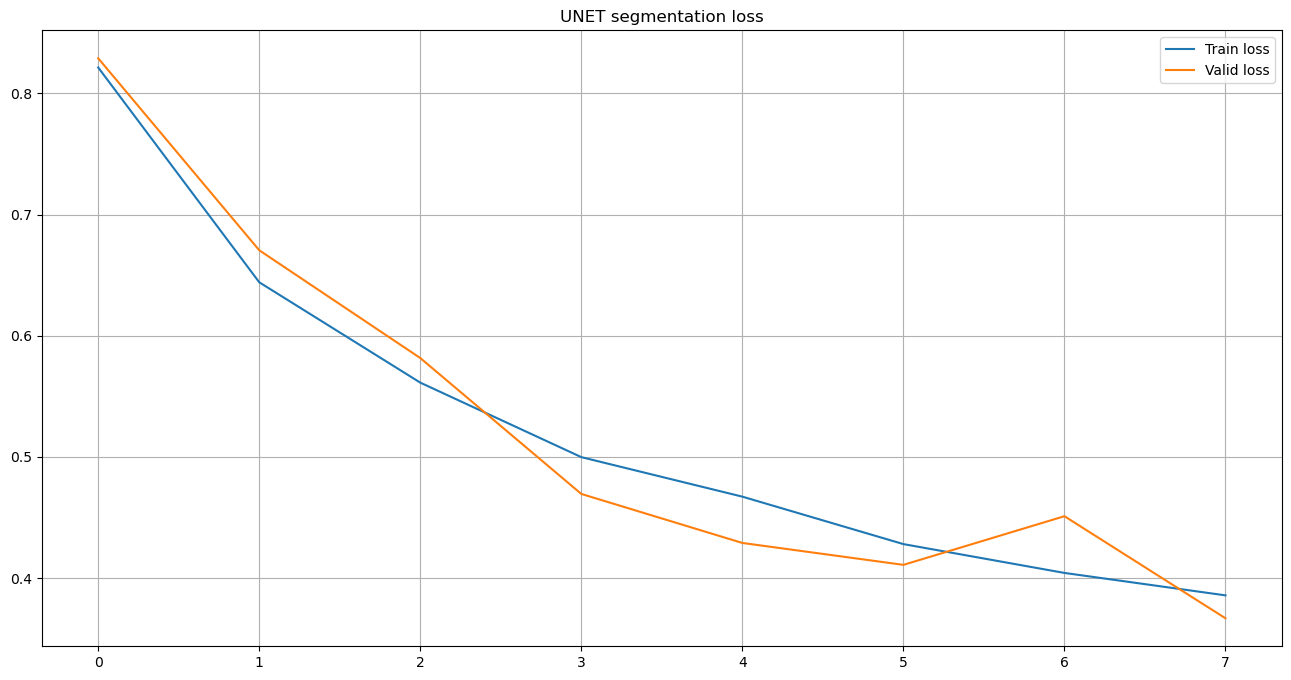

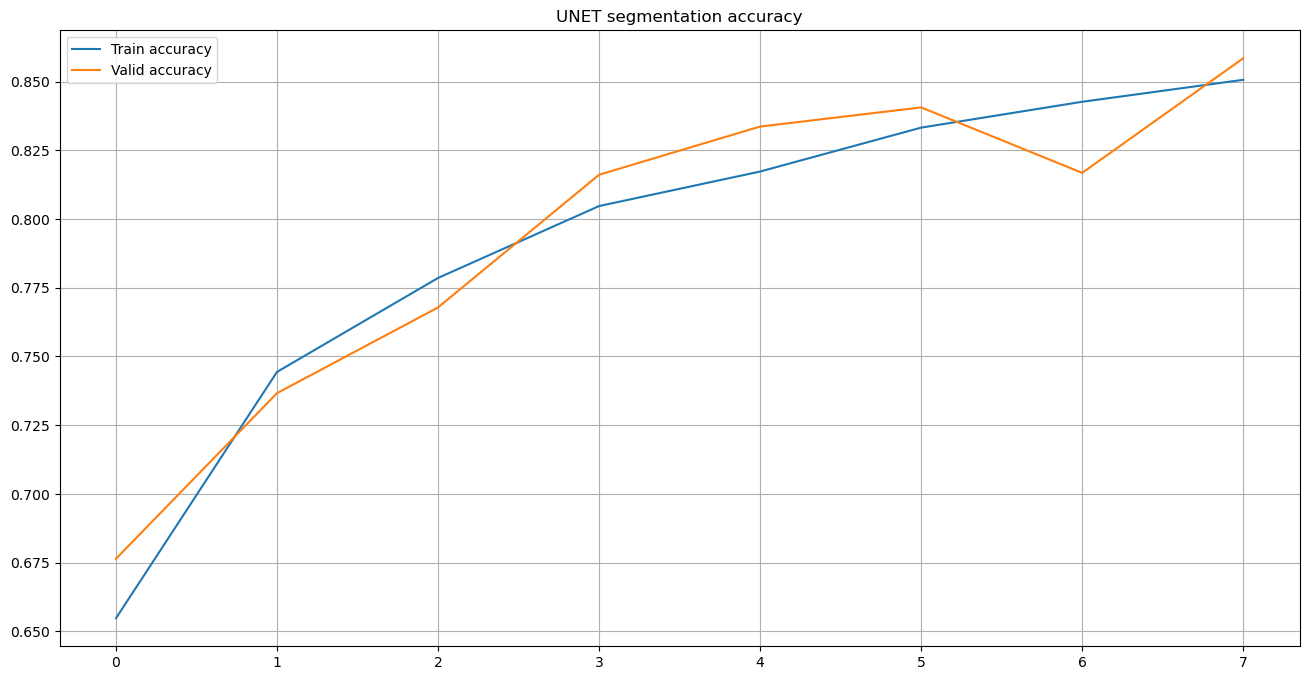

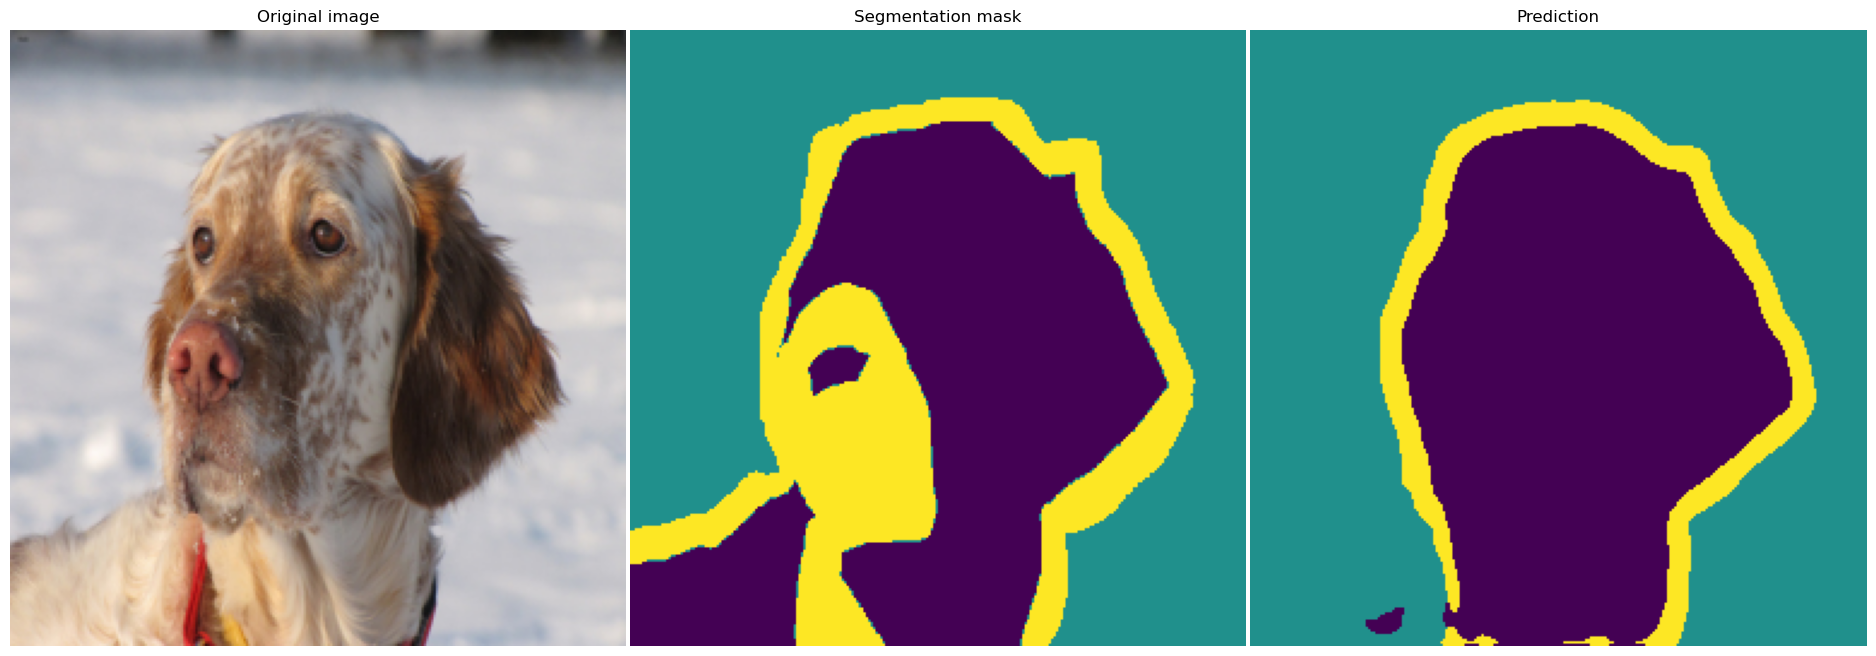

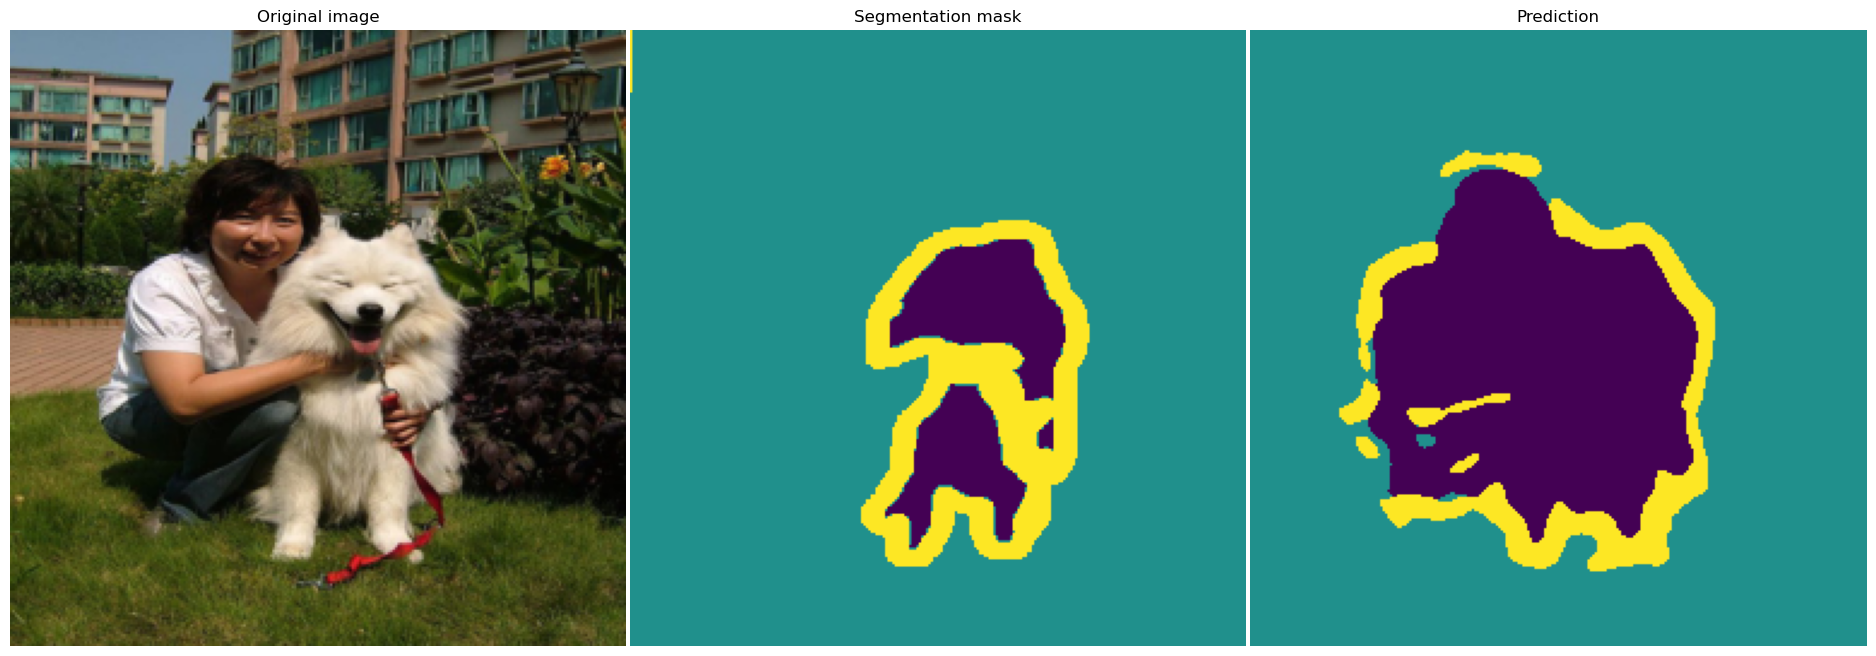

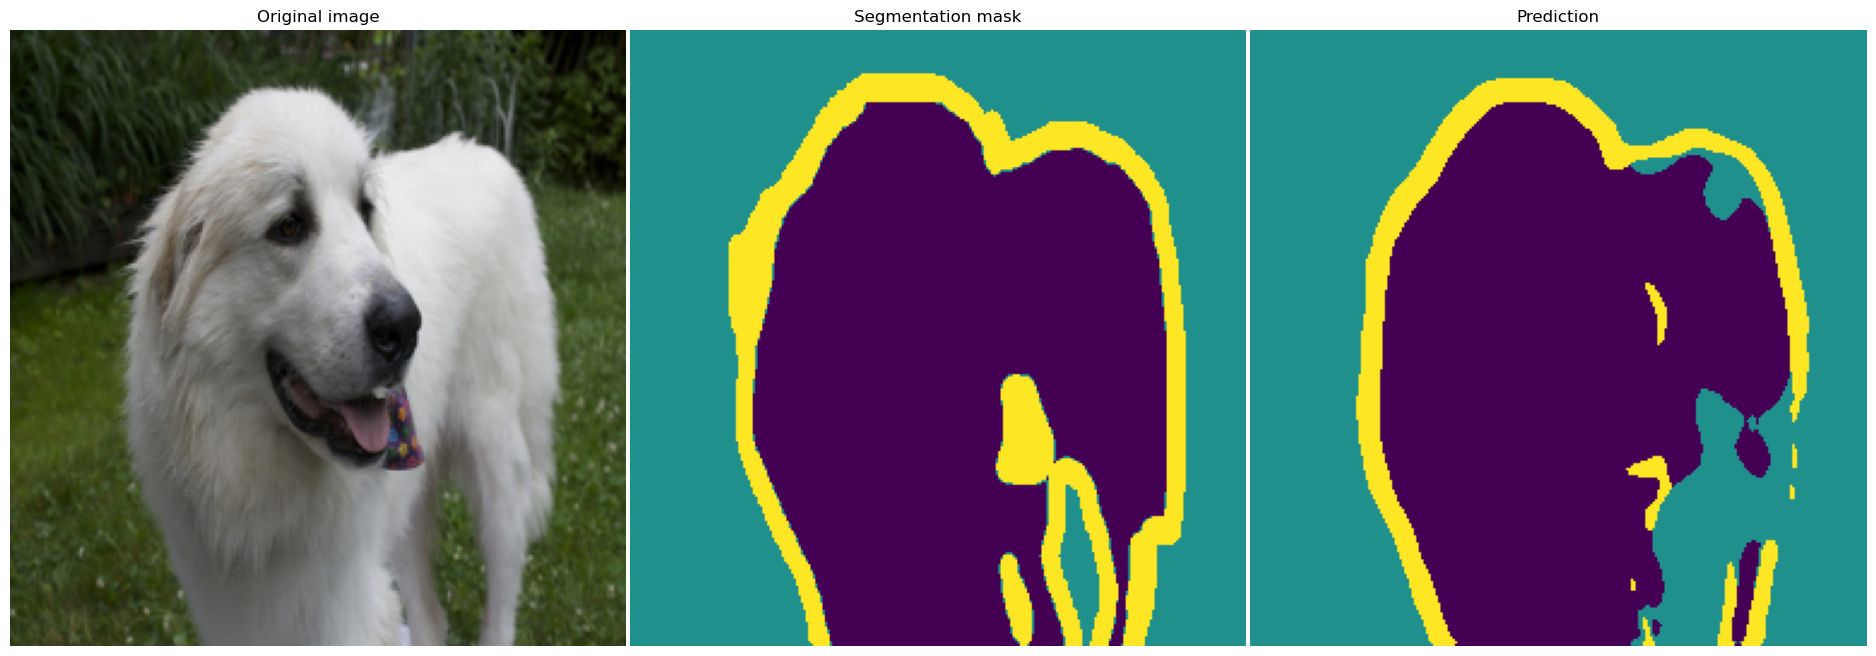

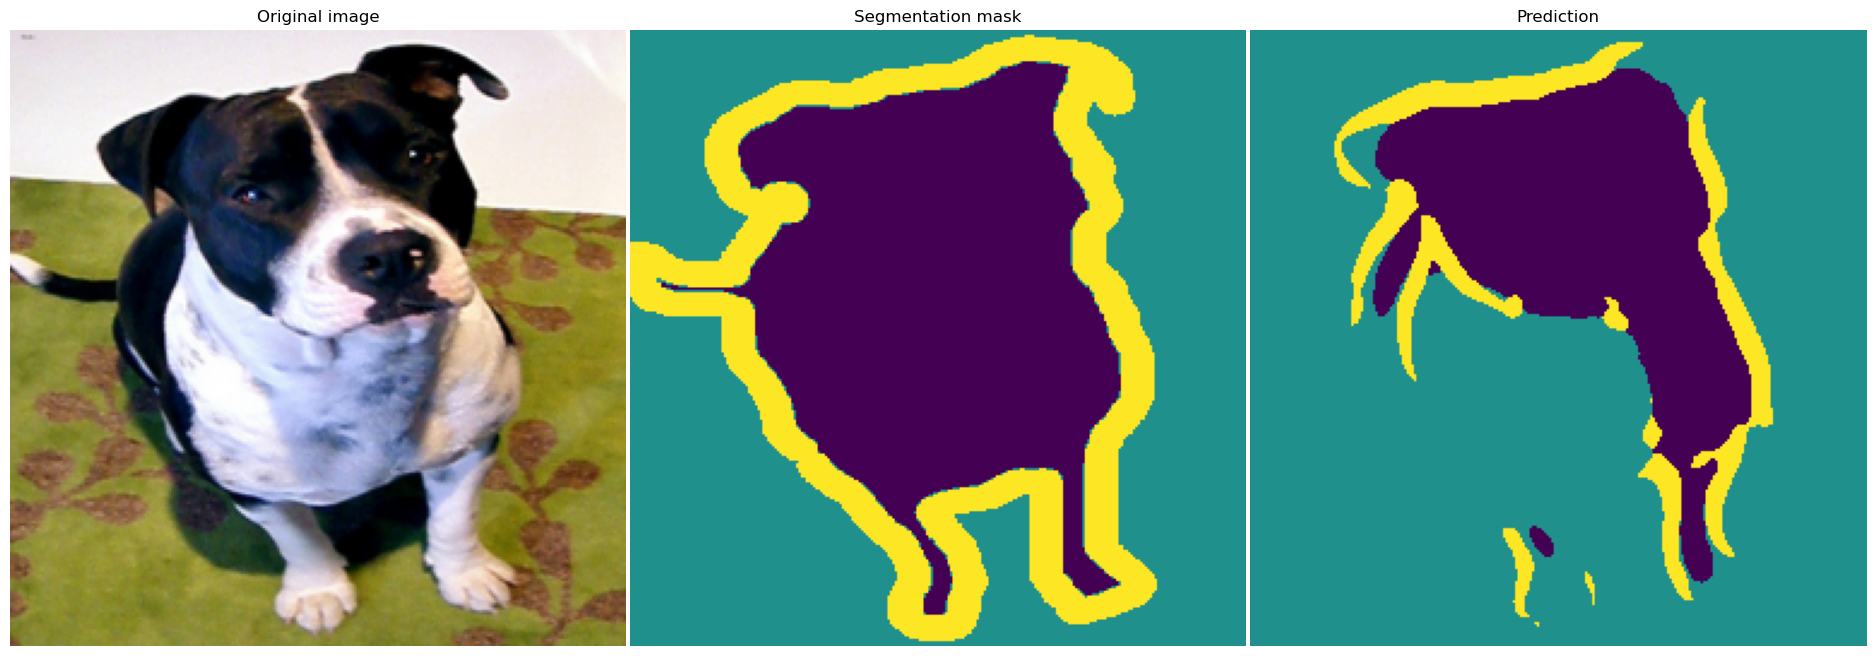

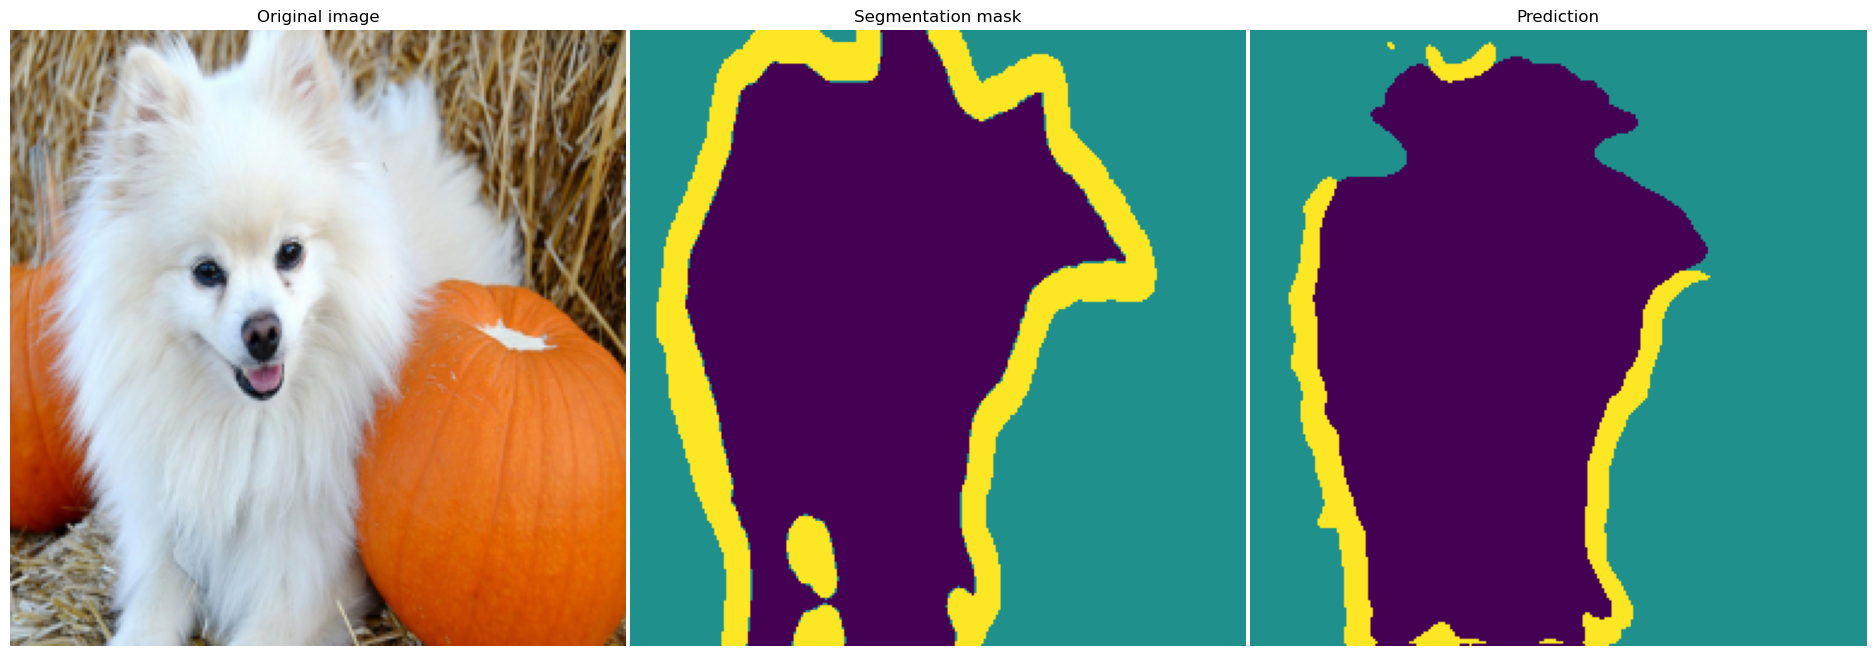

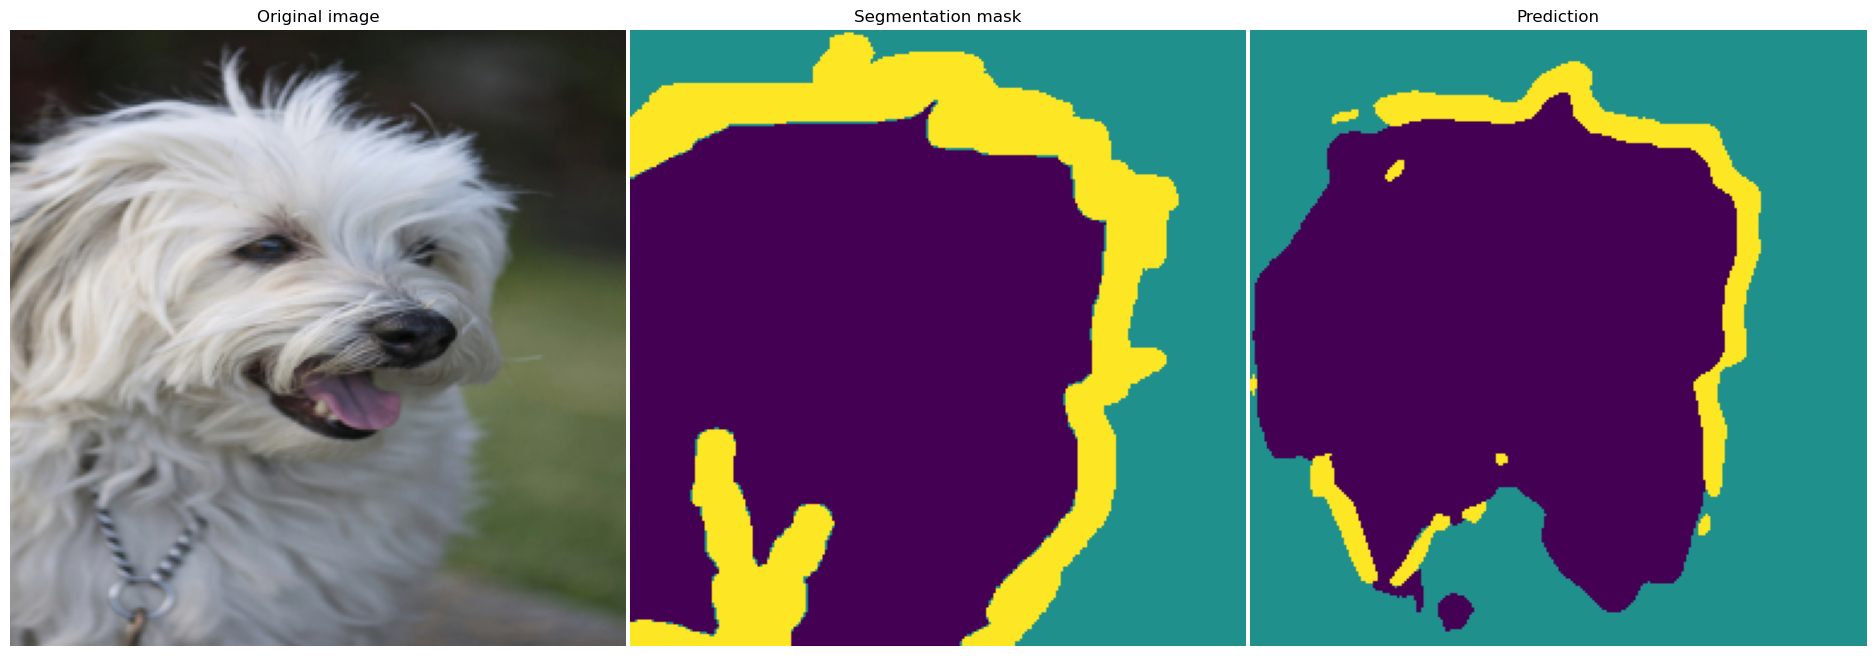

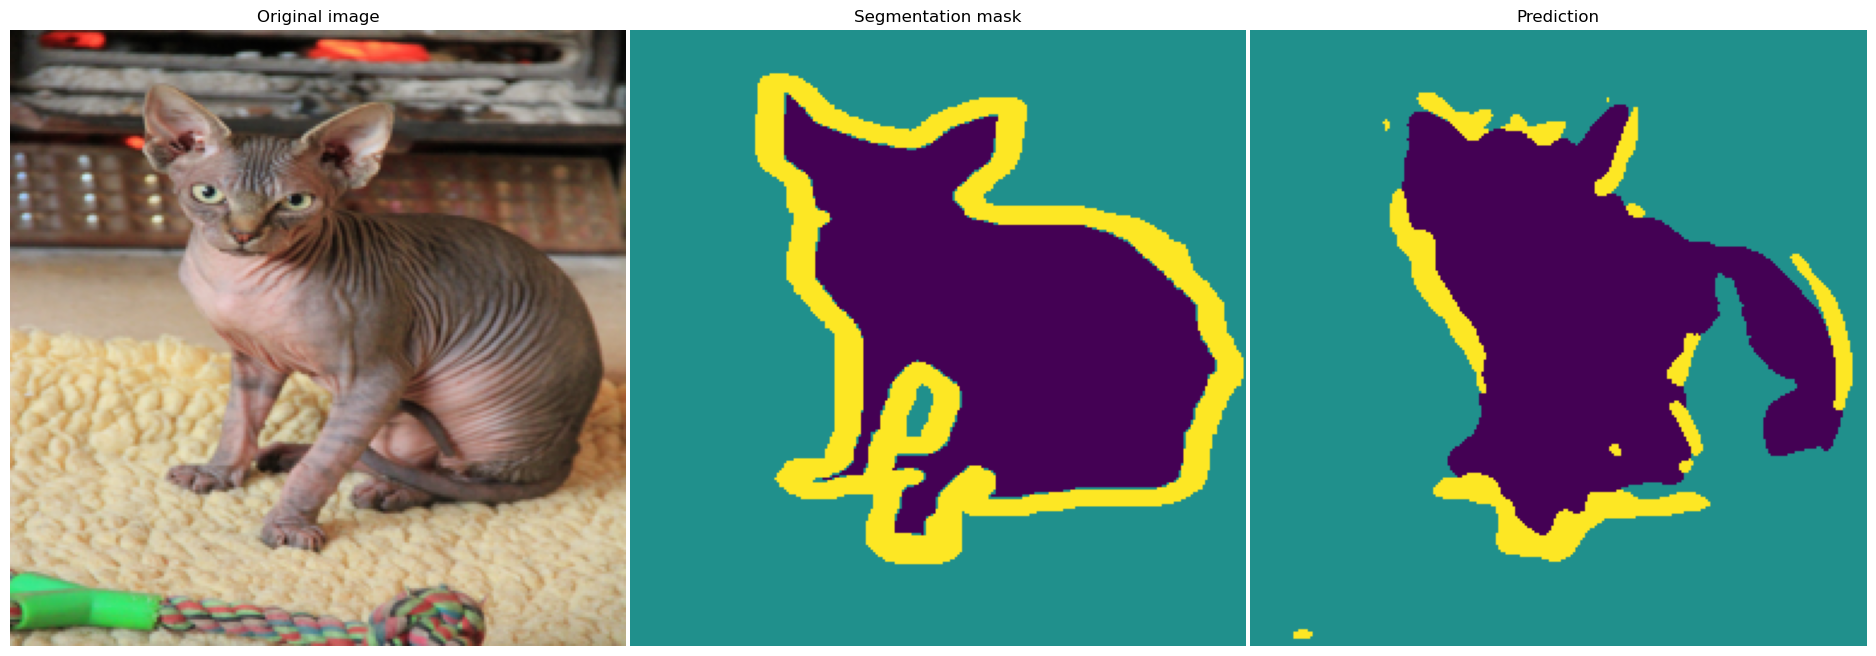

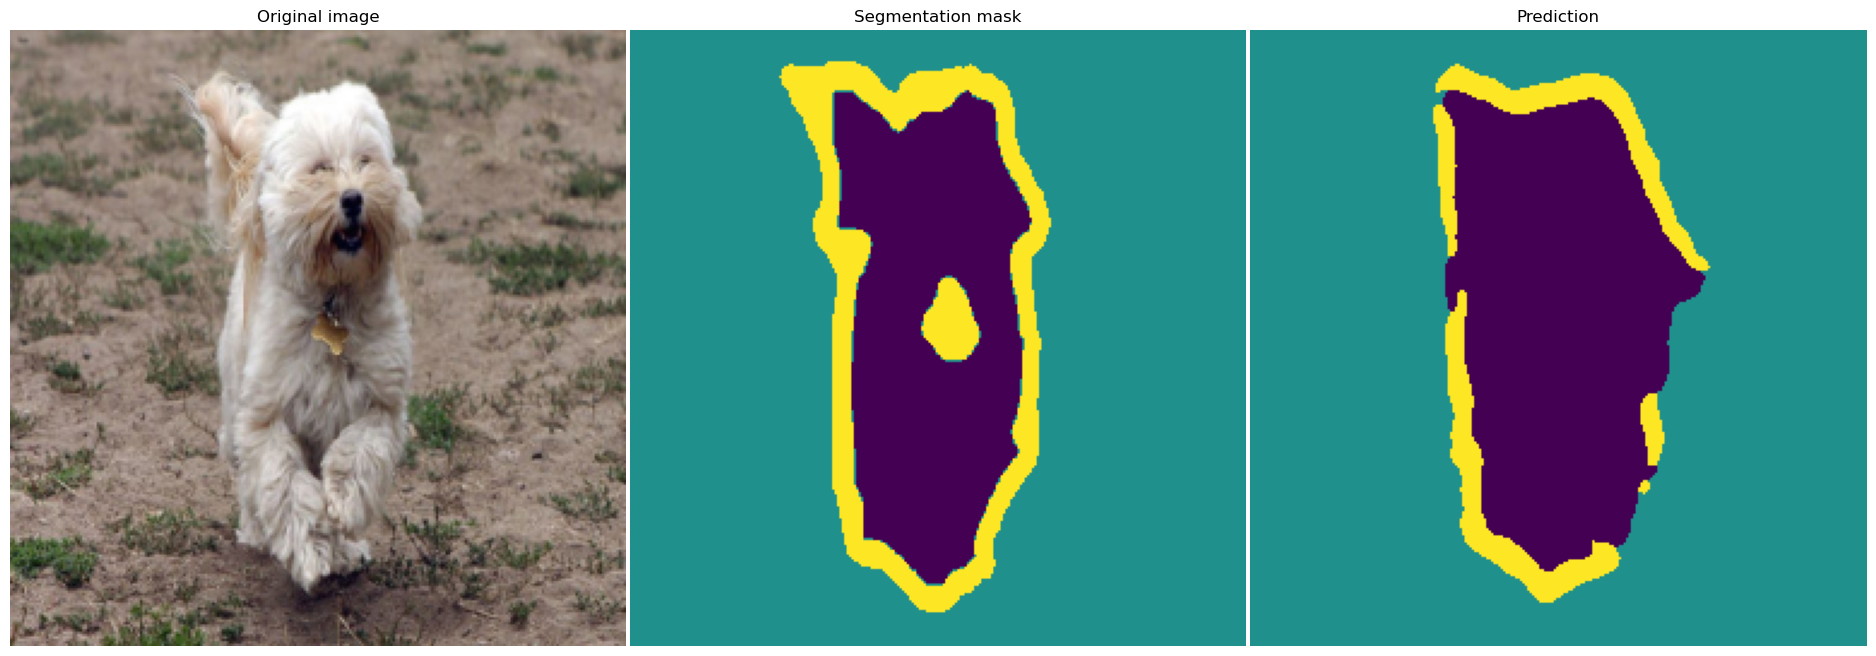

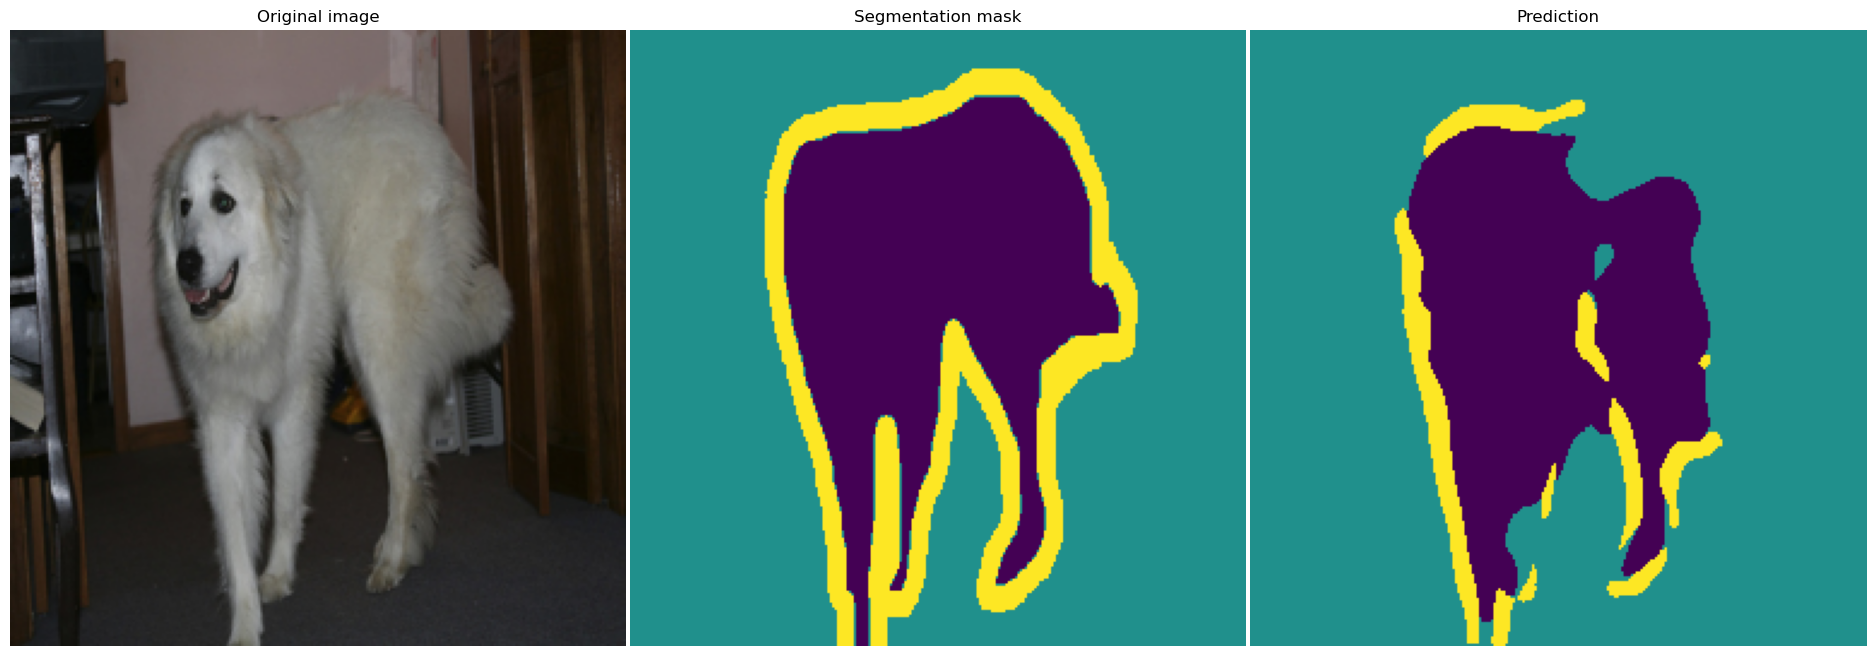

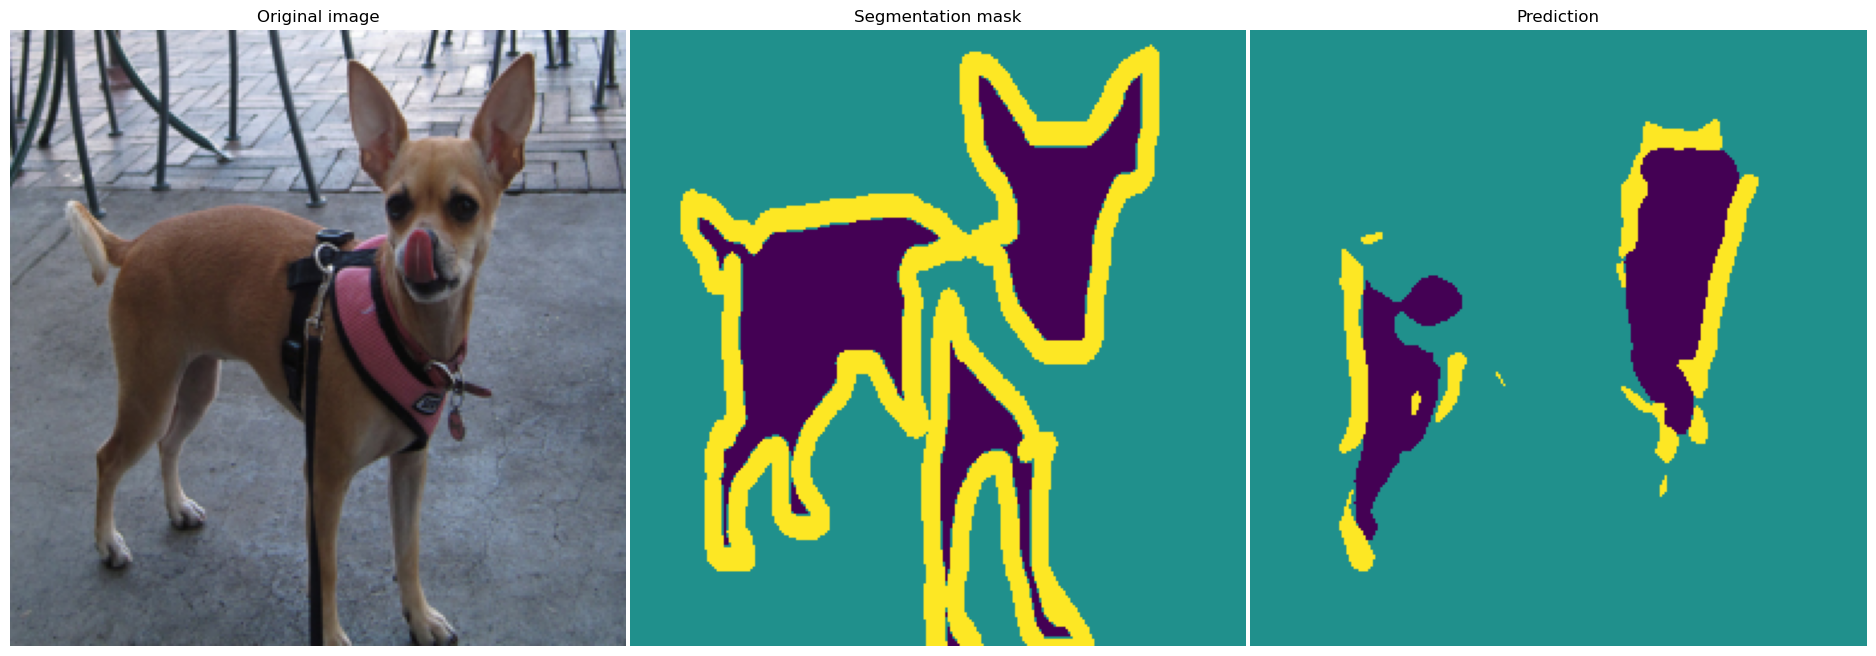

Train:   2%|▋                                    | 1/58 [00:29<27:48, 29.27s/it]

In [ ]:
#!g1.1
whole_train_valid_cycle(model, 15, 'UNET segmentation')

In [ ]:
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

In [ ]:
model.eval()

# Создаем тензор для предсказаний [200, 1, 256, 256]
predictions = torch.zeros(200, 1, 256, 256, dtype=torch.uint8)

# Делаем предсказания
with torch.no_grad():
    for i, sample_idx in enumerate(idx):
        # Получаем изображение и маску из тестовой выборки
        x, true_mask = valid_dataset[sample_idx]
        
        # Добавляем batch dimension и делаем предсказание
        x = x.unsqueeze(0)  # [1, 3, 256, 256]
        output = model(x)   # [1, 3, 256, 256]
        
        # Преобразуем в сегментационную маску [1, 1, 256, 256]
        # Берем argmax по каналам (dim=1) и сохраняем как long
        pred_mask = output.argmax(dim=1, keepdim=True).long()  # [1, 1, 256, 256]
        
        # Сохраняем в общий тензор
        predictions[i] = pred_mask.squeeze(0)  # убираем batch dimension

# Проверяем размерность и значения
print(f"Predictions shape: {predictions.shape}")
print(f"Data type: {predictions.dtype}")
print(f"Min value: {predictions.min()}")
print(f"Max value: {predictions.max()}")
print(f"Unique values: {torch.unique(predictions)}")

In [ ]:
# Сохраняем предсказания
torch.save(predictions, 'test_predictions.pth')

In [ ]:
torch.save(predictions, 'test_predictions.pt')

In [ ]:
torch.save(model.state_dict(), 'trained_model.pth')


model.load_state_dict(torch.load('trained_model.pth'))
model.train()  # Переводим в режим обучения

# Продолжаем обучение с текущими весами
whole_train_valid_cycle(model, 5, 'UNET continued training')  